# Fitting slanted plane for disparity estimation

> See HITNet paper (cvpr 2021) at https://arxiv.org/pdf/2007.12140.pdf and the [TensorFlow code](https://github.com/google-research/google-research/tree/master/hitnet) (only model, no source code) and [3rd party PyTorch code](https://github.com/zjjMaiMai/TinyHITNet). 

## Problem: Fitting a slanted disparity plane

> During propagation we impose a loss on the tile geometry $d$, $d_x$, $d_y$ and the tile confidence $w$. We use the ground truth disparity $d^{\text{gt}}$ and ground truth disparity gradients $d_x^{\text{gt}}$
and $d_y^{\text{gt}}$, which we compute by robustly fitting a plane to $d^{\text{gt}}$ in a $9 \times 9$ window centered at the pixel.

## How to do it?

<center>
<img src="./data/slanted-plane-01.jpg" alt="4 columns of GL_MODELVIEW matrix " width="600"/>
</center>

<center>
<img src="./data/slanted-plane-02.jpg" alt="4 columns of GL_MODELVIEW matrix " width="600"/>
</center>

<center>
<img src="./data/slanted-plane-03.jpg" alt="4 columns of GL_MODELVIEW matrix " width="600"/>
</center>

## The CUDA Code

### 1) See the cuda kernel function at [3d-geometry/src/plane_fitting/plane_fitting_cuda.cu](3d-geometry/src/plane_fitting/plane_fitting_cuda.cu).

```cpp
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <c10/cuda/CUDAGuard.h>

/*
dx * x + dy * y = z(a, b) - z(0, 0);
*/
__global__ void plane_fitting_cuda_foward_kernel(
    float sigma, // e.g., == 0.1;
    float min_disp,
    float max_disp,
    torch::PackedTensorAccessor32<float, 4, torch::RestrictPtrTraits> input,
    torch::PackedTensorAccessor32<int, 4, torch::RestrictPtrTraits> random,
    torch::PackedTensorAccessor32<float, 3, torch::RestrictPtrTraits> output)
    {
    
    const int N = input.size(0);
    const int kernel_H = input.size(1); // e.g., kernel_H = 9
    const int kernel_W = input.size(2); // e.g., kernel_W = 9
    const int L = input.size(3);
    const int I = random.size(2); // iter, e.g., I=256

    const int Index = blockIdx.x * blockDim.x + threadIdx.x;
    if (Index >= N * L)
    {
        return;
    }
    const int n = Index / L;
    const int l = Index % L;

    int max_inlier = 0;
    float best_dx = 0.0f;
    float best_dy = 0.0f;
    
    // E.g., the center pixel is (9//2, 9//2)=(4,4);
    float z00 = input[n][kernel_H / 2][kernel_W / 2][l];

    if (z00 < min_disp || z00 > max_disp)
    {
        output[n][0][l] = best_dx;
        output[n][1][l] = best_dy;
        return;
    }

    for (int i = 0; i < I; ++i)
    {
        int ids0 = random[n][l][i][0];
        ids0 = (ids0 >= kernel_H * kernel_W / 2) ? ids0 + 1 : ids0;
        int x0 = ids0 % kernel_W;
        int y0 = ids0 / kernel_W;
        float z0 = input[n][y0][x0][l];
        if (z0 < min_disp || z0 > max_disp)
        {
            continue;
        }
        int ids1 = random[n][l][i][1];
        ids1 = (ids1 >= kernel_H * kernel_W / 2) ? ids1 + 1 : ids1;
        int x1 = ids1 % kernel_W;
        int y1 = ids1 / kernel_W;
        float z1 = input[n][y1][x1][l];
        if (z1 < min_disp || z1 > max_disp)
        {
            continue;
        }

        // NOTE: CCJ's note:
        // Sample 3 points P1, P2, and Pc to form a plane, and calculate the normal of the plane;
        // where P1 = (x1,y1,z1), P2 = (x2,y2,z2) and Pc =(xc, yc,zc), here xc=kernel_W//2, yc=kernel_H//2, (i.e., 
        // the center of the kernel widnow).
        // Given the vector vec(Pc,P1)=P1-Pc=(x1-xc, y1-yc,z1-zc) and the vector vec(Pc,P2)=P2-Pc=(x2-xc, y2-yc,z2-zc),
        // we can get the normal vector via `cross-product` between vec(Pc,P1) and vec(Pc,P2),
        // i.e., n=vec(Pc,P1) x vec(Pc,P1)
        //               i         j          k
        // vec(P1-Pc)  a=x1-xc  b=y1-yc  c=z1-zc
        // vec(P2-Pc)  d=x2-xc  e=y2-yc  f=z2-zc
        // Therefore, the normal n = i*(bf-ce) - j*(af-cd) + k*(ae-bd)
        // i.e., 
        // vector n = (bf-ce, cd-af, ae-bd) ... (1)
        // Given the normal and one point on the plane, say Pc, 
        // we can get the equation of the plane: Ax + By + Cz + D = 0
        // where the normal     n = (A,B,C) ... (2)
        // the derivative     dz/dx = - A/C ... (3)
        // and the derivative dz/dy = - B/C ... (3)
        // Submitting Eq. 1 to Eq. 2 ,3, and 4, we get
        //   1) dz/dx = -(bf-ce)/(ae-bd) = (ce-bf)/(ae-bd), and  
        //   2) dz/dY = -(cd-af)/(ae-bd) = (af-cd)/(ae-bd);
        //   Done!
        x0 -= (kernel_W / 2);
        y0 -= (kernel_H / 2);

        x1 -= (kernel_W / 2);
        y1 -= (kernel_H / 2);

        float c0 = z0 - z00;
        float c1 = z1 - z00;

        float dx = (c0 * y1 - y0 * c1) / (x0 * y1 - y0 * x1);
        float dy = (x0 * c1 - c0 * x1) / (x0 * y1 - y0 * x1);

        int inlier = 0;
        for (int h = 0; h < kernel_H; ++h)
        {
            for (int w = 0; w < kernel_W; ++w)
            {
                float zwh = input[n][h][w][l];
                if (zwh < min_disp || zwh > max_disp){
                    continue;
                }

                float err = dx * (w - kernel_W / 2) + dy * (h - kernel_H / 2) - zwh + z00;
                if (err < 0){
                    err = -err;
                }

                if (err < sigma){
                    ++inlier;
                }
            }
        }

        if (inlier > max_inlier)
        {
            max_inlier = inlier;
            best_dx = dx;
            best_dy = dy;
        }
    }

    output[n][0][l] = best_dx;
    output[n][1][l] = best_dy;
    return;
}

/* CCJ's note: 
 * Input is a disparity map D in shape of [N,C,H,W]=[N,1,H,W]
 * To fit a plane to disparity map D in a k x k= 9x9 window centered
 * at the pixel in D.
 * So here the input is actually a unfolded version of the original
 * disparity map D, e.g., `input` = torch.unfold(D, kernel_size=k, padding=k//2, stride=1);
 * resulting the `input` here in shape of [N*C, k, k, L]=[N,k,k,H*W] (with C=1);
 */
torch::Tensor plane_fitting_cuda_foward(
    torch::Tensor input, // [N*C, k, k, L]=[N,k,k,H*W] 
    int iter, 
    float sigma, 
    float min_disp, 
    float max_disp
    ){
    const auto N = input.size(0); // batch dimension
    const auto kernel_H = input.size(1); // kernel height
    const auto kernel_W = input.size(2); // kernel width
    const auto L = input.size(3); // number of pixels

    torch::Tensor random = torch::randint(
        0, kernel_H * kernel_W - 1, 
        {N, L, iter, 2}, 
        torch::dtype(torch::kInt32).device(input.device())
        );
    torch::Tensor output = torch::ones(
        {N, 2, L}, 
        torch::dtype(torch::kFloat32).device(input.device())
        );

    const at::cuda::OptionalCUDAGuard guard(device_of(input));
    plane_fitting_cuda_foward_kernel<<<(N * L + 1023) / 1024, 1024>>>(
        sigma,
        min_disp,
        max_disp,
        input.packed_accessor32<float, 4, torch::RestrictPtrTraits>(),
        random.packed_accessor32<int, 4, torch::RestrictPtrTraits>(),
        output.packed_accessor32<float, 3, torch::RestrictPtrTraits>());
    return output;
}
```

### 2) See the cpp function at [3d-geometry/src/plane_fitting/plane_fitting.cpp](3d-geometry/src/plane_fitting/plane_fitting.cpp).

```cpp
#include <torch/extension.h>

torch::Tensor plane_fitting_cuda_foward(torch::Tensor input, int iter, float sigma, float min_disp, float max_disp);

torch::Tensor plane_fitting_foward(torch::Tensor input, int iter, float sigma, float min_disp, float max_disp)
{
    return plane_fitting_cuda_foward(input, iter, sigma, min_disp, max_disp);
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m)
{
    m.def("plane_fitting_foward", &plane_fitting_foward, "plane_fitting_foward");
}
```

## Call the cuda library in Python

### 1) Compile it using `torch.utils.cpp_extension.CUDAExtension`

We write a `setup.py` file and a bash to compile the cpp/cuda codes.

```bash
./compile.sh
```

- Then the compiled library is saved as [plane_fitting_c.cpython-38-x86_64-linux-gnu.so](build/lib/plane_fitting_c.cpython-38-x86_64-linux-gnu.so). 
- The Python function is originally at [3d-geometry/src/HitnetModule/plane_fitting.py](3d-geometry/src/HitnetModule/plane_fitting.py), and copied to [3d-geometry/build/lib/HitnetModule/plane_fitting.py](3d-geometry/build/lib/HitnetModule/plane_fitting.py) for using.

The `planme_fitting.py` file defines a module _plane_fitting_ via `plane_fitting = PlaneFittingFunction.apply`

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from plane_fitting_c import plane_fitting_foward


class PlaneFittingFunction(Function):
    @staticmethod
    def forward(
        ctx,
        input: torch.Tensor, #[N,C=1,H,W]
        iter: int,
        sigma: float,
        kernel_size: int,
        min_disp: float,
        max_disp: float,
    ):
        assert input.is_cuda
        assert len(input.size()) == 4

        unfold = F.unfold(
            input,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=1
        ) # [N, k*k, L], L=H*W
        
        # [N, k, k, L]
        unfold = unfold.reshape(-1, kernel_size, kernel_size, unfold.size(2))
        
        # [N, 2, L], here 2 for d_x, and d_y
        unfold = plane_fitting_foward(unfold, iter, sigma, min_disp, max_disp)
        
        fold = F.fold(unfold, 
                    output_size = input.size()[2:], 
                    kernel_size = 1) #[N,2,H,W]
        return fold


plane_fitting = PlaneFittingFunction.apply

ModuleNotFoundError: No module named 'plane_fitting_c'

- We do not see the error if we run the code in ternimal (i.e., not on the Jupyter notebook). See `plane_fitting_sf.py` to fit disparity planes on SceneFlow dataset.

- To run it on Jupyter nootbook, we follow the JIT (just-in-time) loading - [Loads a PyTorch C++ extension just-in-time (JIT)](https://pytorch.org/docs/stable/cpp_extension.html#torch.utils.cpp_extension.load). See below.

### 2) Compile it using `torch.utils.cpp_extension.load` for JIT loading

See the code at [3d-geometry/demo_plane_fitting.py](3d-geometry/demo_plane_fitting.py).

Using /home/ccj/.cache/torch_extensions/py38_cu113 as PyTorch extensions root...
No modifications detected for re-loaded extension module extension, skipping build step...
Loading extension module extension...
x shape =  (2, 540, 960) <class 'numpy.float32'>
dxy_clr = torch.Size([1, 3, 540, 960]), disp_clr = torch.Size([1, 3, 540, 960])
Saved results to ./data/clr_disp_dispxy.png


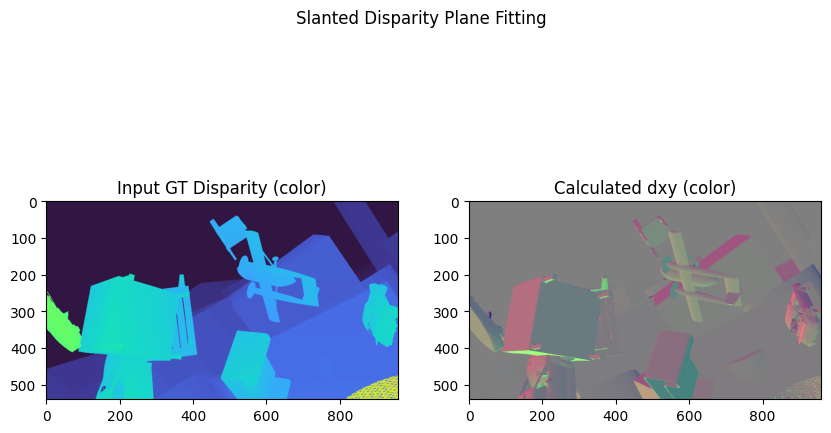

In [10]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import Function
import torchvision

import pfmutil as pfm
import io
from PIL import Image

import numpy as np

#import pycuda.driver as cuda
#import pycuda.autoinit
#import pycuda.compiler as nvcc


from torch.utils.cpp_extension import load

# Compile the PCA kernel using NVRTC CUDA
planefitting_module = load(
    name='extension',
    sources=[
        "src/plane_fitting/plane_fitting.cpp",
        "src/plane_fitting/plane_fitting_cuda.cu",
        ],
    extra_cflags=['-O3'],
    verbose=True)

plane_fitting_foward = planefitting_module.plane_fitting_foward


class PlaneFittingFunction(Function):
    @staticmethod
    def forward(
        ctx,
        input: torch.Tensor, #[N,C=1,H,W]
        iter: int,
        sigma: float,
        kernel_size: int,
        min_disp: float,
        max_disp: float,
    ):
        assert input.is_cuda
        assert len(input.size()) == 4

        unfold = F.unfold(
            input,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=1
        ) # [N, k*k, L], L=H*W
        
        # [N, k, k, L]
        unfold = unfold.reshape(-1, kernel_size, kernel_size, unfold.size(2))
        
        # [N, 2, L], here 2 for d_x, and d_y
        unfold = plane_fitting_foward(unfold, iter, sigma, min_disp, max_disp)
        
        fold = F.fold(unfold, 
                    output_size = input.size()[2:], 
                    kernel_size = 1) #[N,2,H,W]
        return fold


plane_fitting = PlaneFittingFunction.apply


@torch.no_grad()
def dxy_colormap(dxy):
    dxy = dxy * 3
    dxy = F.pad(dxy, (0, 0, 0, 0, 0, 1)) # pad by (0, 0), (0, 0), and (0, 1)
    dxy[:, 1, :, :] *= -1
    dxy = torch.clip(dxy * 0.5 + 0.5, 0, 1)
    return dxy

# fmt: off
turbo_map = torch.Tensor([
    [ 0.18995,0.19483,0.19956,0.20415,0.20860,0.21291,0.21708,0.22111,0.22500,0.22875,0.23236,0.23582,0.23915,0.24234,0.24539,0.24830,0.25107,0.25369,0.25618,0.25853,0.26074,0.26280,0.26473,0.26652,0.26816,0.26967,0.27103,0.27226,0.27334,0.27429,0.27509,0.27576,0.27628,0.27667,0.27691,0.27701,0.27698,0.27680,0.27648,0.27603,0.27543,0.27469,0.27381,0.27273,0.27106,0.26878,0.26592,0.26252,0.25862,0.25425,0.24946,0.24427,0.23874,0.23288,0.22676,0.22039,0.21382,0.20708,0.20021,0.19326,0.18625,0.17923,0.17223,0.16529,0.15844,0.15173,0.14519,0.13886,0.13278,0.12698,0.12151,0.11639,0.11167,0.10738,0.10357,0.10026,0.09750,0.09532,0.09377,0.09287,0.09267,0.09320,0.09451,0.09662,0.09958,0.10342,0.10815,0.11374,0.12014,0.12733,0.13526,0.14391,0.15323,0.16319,0.17377,0.18491,0.19659,0.20877,0.22142,0.23449,0.24797,0.26180,0.27597,0.29042,0.30513,0.32006,0.33517,0.35043,0.36581,0.38127,0.39678,0.41229,0.42778,0.44321,0.45854,0.47375,0.48879,0.50362,0.51822,0.53255,0.54658,0.56026,0.57357,0.58646,0.59891,0.61088,0.62233,0.63323,0.64362,0.65394,0.66428,0.67462,0.68494,0.69525,0.70553,0.71577,0.72596,0.73610,0.74617,0.75617,0.76608,0.77591,0.78563,0.79524,0.80473,0.81410,0.82333,0.83241,0.84133,0.85010,0.85868,0.86709,0.87530,0.88331,0.89112,0.89870,0.90605,0.91317,0.92004,0.92666,0.93301,0.93909,0.94489,0.95039,0.95560,0.96049,0.96507,0.96931,0.97323,0.97679,0.98000,0.98289,0.98549,0.98781,0.98986,0.99163,0.99314,0.99438,0.99535,0.99607,0.99654,0.99675,0.99672,0.99644,0.99593,0.99517,0.99419,0.99297,0.99153,0.98987,0.98799,0.98590,0.98360,0.98108,0.97837,0.97545,0.97234,0.96904,0.96555,0.96187,0.95801,0.95398,0.94977,0.94538,0.94084,0.93612,0.93125,0.92623,0.92105,0.91572,0.91024,0.90463,0.89888,0.89298,0.88691,0.88066,0.87422,0.86760,0.86079,0.85380,0.84662,0.83926,0.83172,0.82399,0.81608,0.80799,0.79971,0.79125,0.78260,0.77377,0.76476,0.75556,0.74617,0.73661,0.72686,0.71692,0.70680,0.69650,0.68602,0.67535,0.66449,0.65345,0.64223,0.63082,0.61923,0.60746,0.59550,0.58336,0.57103,0.55852,0.54583,0.53295,0.51989,0.50664,0.49321,0.47960 ],
    [ 0.07176,0.08339,0.09498,0.10652,0.11802,0.12947,0.14087,0.15223,0.16354,0.17481,0.18603,0.19720,0.20833,0.21941,0.23044,0.24143,0.25237,0.26327,0.27412,0.28492,0.29568,0.30639,0.31706,0.32768,0.33825,0.34878,0.35926,0.36970,0.38008,0.39043,0.40072,0.41097,0.42118,0.43134,0.44145,0.45152,0.46153,0.47151,0.48144,0.49132,0.50115,0.51094,0.52069,0.53040,0.54015,0.54995,0.55979,0.56967,0.57958,0.58950,0.59943,0.60937,0.61931,0.62923,0.63913,0.64901,0.65886,0.66866,0.67842,0.68812,0.69775,0.70732,0.71680,0.72620,0.73551,0.74472,0.75381,0.76279,0.77165,0.78037,0.78896,0.79740,0.80569,0.81381,0.82177,0.82955,0.83714,0.84455,0.85175,0.85875,0.86554,0.87211,0.87844,0.88454,0.89040,0.89600,0.90142,0.90673,0.91193,0.91701,0.92197,0.92680,0.93151,0.93609,0.94053,0.94484,0.94901,0.95304,0.95692,0.96065,0.96423,0.96765,0.97092,0.97403,0.97697,0.97974,0.98234,0.98477,0.98702,0.98909,0.99098,0.99268,0.99419,0.99551,0.99663,0.99755,0.99828,0.99879,0.99910,0.99919,0.99907,0.99873,0.99817,0.99739,0.99638,0.99514,0.99366,0.99195,0.98999,0.98775,0.98524,0.98246,0.97941,0.97610,0.97255,0.96875,0.96470,0.96043,0.95593,0.95121,0.94627,0.94113,0.93579,0.93025,0.92452,0.91861,0.91253,0.90627,0.89986,0.89328,0.88655,0.87968,0.87267,0.86553,0.85826,0.85087,0.84337,0.83576,0.82806,0.82025,0.81236,0.80439,0.79634,0.78823,0.78005,0.77181,0.76352,0.75519,0.74682,0.73842,0.73000,0.72140,0.71250,0.70330,0.69382,0.68408,0.67408,0.66386,0.65341,0.64277,0.63193,0.62093,0.60977,0.59846,0.58703,0.57549,0.56386,0.55214,0.54036,0.52854,0.51667,0.50479,0.49291,0.48104,0.46920,0.45740,0.44565,0.43399,0.42241,0.41093,0.39958,0.38836,0.37729,0.36638,0.35566,0.34513,0.33482,0.32473,0.31489,0.30530,0.29599,0.28696,0.27824,0.26981,0.26152,0.25334,0.24526,0.23730,0.22945,0.22170,0.21407,0.20654,0.19912,0.19182,0.18462,0.17753,0.17055,0.16368,0.15693,0.15028,0.14374,0.13731,0.13098,0.12477,0.11867,0.11268,0.10680,0.10102,0.09536,0.08980,0.08436,0.07902,0.07380,0.06868,0.06367,0.05878,0.05399,0.04931,0.04474,0.04028,0.03593,0.03169,0.02756,0.02354,0.01963,0.01583 ],
    [ 0.23217,0.26149,0.29024,0.31844,0.34607,0.37314,0.39964,0.42558,0.45096,0.47578,0.50004,0.52373,0.54686,0.56942,0.59142,0.61286,0.63374,0.65406,0.67381,0.69300,0.71162,0.72968,0.74718,0.76412,0.78050,0.79631,0.81156,0.82624,0.84037,0.85393,0.86692,0.87936,0.89123,0.90254,0.91328,0.92347,0.93309,0.94214,0.95064,0.95857,0.96594,0.97275,0.97899,0.98461,0.98930,0.99303,0.99583,0.99773,0.99876,0.99896,0.99835,0.99697,0.99485,0.99202,0.98851,0.98436,0.97959,0.97423,0.96833,0.96190,0.95498,0.94761,0.93981,0.93161,0.92305,0.91416,0.90496,0.89550,0.88580,0.87590,0.86581,0.85559,0.84525,0.83484,0.82437,0.81389,0.80342,0.79299,0.78264,0.77240,0.76230,0.75237,0.74265,0.73316,0.72393,0.71500,0.70599,0.69651,0.68660,0.67627,0.66556,0.65448,0.64308,0.63137,0.61938,0.60713,0.59466,0.58199,0.56914,0.55614,0.54303,0.52981,0.51653,0.50321,0.48987,0.47654,0.46325,0.45002,0.43688,0.42386,0.41098,0.39826,0.38575,0.37345,0.36140,0.34963,0.33816,0.32701,0.31622,0.30581,0.29581,0.28623,0.27712,0.26849,0.26038,0.25280,0.24579,0.23937,0.23356,0.22835,0.22370,0.21960,0.21602,0.21294,0.21032,0.20815,0.20640,0.20504,0.20406,0.20343,0.20311,0.20310,0.20336,0.20386,0.20459,0.20552,0.20663,0.20788,0.20926,0.21074,0.21230,0.21391,0.21555,0.21719,0.21880,0.22038,0.22188,0.22328,0.22456,0.22570,0.22667,0.22744,0.22800,0.22831,0.22836,0.22811,0.22754,0.22663,0.22536,0.22369,0.22161,0.21918,0.21650,0.21358,0.21043,0.20706,0.20348,0.19971,0.19577,0.19165,0.18738,0.18297,0.17842,0.17376,0.16899,0.16412,0.15918,0.15417,0.14910,0.14398,0.13883,0.13367,0.12849,0.12332,0.11817,0.11305,0.10797,0.10294,0.09798,0.09310,0.08831,0.08362,0.07905,0.07461,0.07031,0.06616,0.06218,0.05837,0.05475,0.05134,0.04814,0.04516,0.04243,0.03993,0.03753,0.03521,0.03297,0.03082,0.02875,0.02677,0.02487,0.02305,0.02131,0.01966,0.01809,0.01660,0.01520,0.01387,0.01264,0.01148,0.01041,0.00942,0.00851,0.00769,0.00695,0.00629,0.00571,0.00522,0.00481,0.00449,0.00424,0.00408,0.00401,0.00401,0.00410,0.00427,0.00453,0.00486,0.00529,0.00579,0.00638,0.00705,0.00780,0.00863,0.00955,0.01055 ],
])
# fmt: on

@torch.no_grad()
def apply_colormap(n1hw, mode="turbo"):
    color_map = None
    if mode == "turbo":
        color_map = torch.transpose(turbo_map, 1, 0)

    colormap = color_map.to(device=n1hw.device, dtype=torch.float32)
    colormap = colormap[n1hw[:, 0]]
    return colormap.permute(0, 3, 1, 2)

def encode_image_as_16bit_png(data, filename):
    with io.BytesIO() as im_bytesio:
        height, width = data.shape
        array_bytes = data.astype(np.uint16).tobytes()
        array_img = Image.new('I', (width, height))
        array_img.frombytes(array_bytes, 'raw', 'I;16')
        array_img.save(im_bytesio, format='png')
        with open(filename, 'wb') as f:
            f.write(im_bytesio.getvalue())

def encode_image_as_pfm(data, filename):
    with open(filename, 'wb') as f:
        f.write(bytes('Pf\n', 'ascii'))
        f.write(bytes('%d %d\n' % (data.shape[1], data.shape[0]), 'ascii'))
        f.write(bytes('-1.0\n', 'ascii'))
        f.write(data[::-1].tobytes())  # PFM stores data upside down

if __name__ == "__main__": 
    with torch.no_grad():
        cuda_id = 1
        pfm_path = './data/0006_left.pfm'
        disp = pfm.readPFM(pfm_path)
        disp = torch.from_numpy(disp.copy())[None, None, :, :].cuda(cuda_id)
        """
        dxy = plane_fitting(
            ctx=None,
            input= disp, #[1,1,H,W]
            iter=256, 
            sigma=0.1, 
            kernel_size=9, 
            min_disp=0, 
            max_disp=1e5) #[B,2,H,W]
        """
        dxy = plane_fitting(
            disp, #[1,1,H,W]
            256, # iter
            0.1, # sigma=0.1, 
            9, # kernel_size=9, 
            0, #min_disp=0, 
            1e5 #max_disp=1e5
            ) #[B,2,H,W]
        
        dxy_np = dxy[0].cpu().numpy()#[2,H,W]
        print ("x shape = ", dxy_np.shape, type(dxy_np[0,0,0])) # (2, H, W), float32
        #e.g., == . x shape =  (2, 540, 960) <class 'numpy.float32'>;

        dx_path = './data/our_slant_window_dx.pfm'
        dy_path = './data/our_slant_window_dy.pfm'
        dxy_path = './data/our_slant_window_dxy_color.png'
        pfm.save(dx_path, dxy_np[0].astype(np.float32))
        pfm.save(dy_path, dxy_np[1].astype(np.float32))
        
        dxy_clr = dxy_colormap(dxy) #[1,3,H,W]
        disp_clr = apply_colormap(disp.long()) #[1,3,H,W]
        print (f"dxy_clr = {dxy_clr.shape}, disp_clr = {disp_clr.shape}")
        output = torch.cat([disp_clr, dxy_clr], dim=0)
        tmp_path = './data/clr_disp_dispxy.png'
        torchvision.utils.save_image(output, tmp_path, nrow=1)
        print (f"Saved results to {tmp_path}")

        if 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 6))
            #fig, axes = plt.subplots(1, 2)
            axes[0].imshow(disp_clr[0].permute(1,2,0).cpu().numpy())
            axes[1].imshow(dxy_clr[0].permute(1,2,0).cpu().numpy())
            axes[0].title.set_text("Input GT Disparity (color)")
            axes[1].title.set_text("Calculated dxy (color)")
            plt.suptitle("Slanted Disparity Plane Fitting")
            plt.show()

Now it works! Cheers!